In [3]:
import os
import pickle
import sys
import warnings
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import xgboost
from scipy.stats import spearmanr
from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm.auto import tqdm

# 表示用の設定を変更します
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120

In [4]:
dataset_dir="../data_dir"

In [5]:
# 読み込むファイルを定義します。
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv.gz",
    "stock_price": f"{dataset_dir}/stock_price.csv.gz",
    "stock_fin": f"{dataset_dir}/stock_fin.csv.gz",
    # 本チュートリアルでは使用しないため、コメントアウトしています。
    # "stock_fin_price": f"{dataset_dir}/stock_fin_price.csv.gz",
    "stock_labels": f"{dataset_dir}/stock_labels.csv.gz",
}

# ファイルを読み込みます
dfs = {}
for k, v in inputs.items():
    print(k)
    dfs[k] = pd.read_csv(v)
    # DataFrameのindexを設定します。
    if k == "stock_price":
        dfs[k].loc[:, "datetime"] = pd.to_datetime(
            dfs[k].loc[:, "EndOfDayQuote Date"]
        )
        dfs[k].set_index("datetime", inplace=True)
    elif k in ["stock_fin", "stock_fin_price", "stock_labels"]:
        dfs[k].loc[:, "datetime"] = pd.to_datetime(
            dfs[k].loc[:, "base_date"]
        )
        dfs[k].set_index("datetime", inplace=True)

stock_list
stock_price
stock_fin
stock_labels


In [6]:
for k in inputs.keys():
    print(k)
    print(dfs[k].info())
    print(dfs[k].head(1).T)

stock_list
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3711 entries, 0 to 3710
Data columns (total 14 columns):
prediction_target                            3711 non-null bool
Effective Date                               3711 non-null int64
Local Code                                   3711 non-null int64
Name (English)                               3711 non-null object
Section/Products                             3711 non-null object
33 Sector(Code)                              3711 non-null int64
33 Sector(name)                              3711 non-null object
17 Sector(Code)                              3711 non-null int64
17 Sector(name)                              3711 non-null object
Size Code (New Index Series)                 3711 non-null object
Size (New Index Series)                      3711 non-null object
IssuedShareEquityQuote AccountingStandard    3708 non-null object
IssuedShareEquityQuote ModifyDate            3708 non-null object
IssuedShareEquityQuote IssuedS

(64421, 44)
base_date                                                         0
Local Code                                                        0
Result_FinancialStatement AccountingStandard                    239
Result_FinancialStatement FiscalPeriodEnd                       239
Result_FinancialStatement ReportType                            239
Result_FinancialStatement FiscalYear                            239
Result_FinancialStatement ModifyDate                            239
Result_FinancialStatement CompanyType                           239
Result_FinancialStatement ChangeOfFiscalYearEnd                 239
Result_FinancialStatement NetSales                              256
Result_FinancialStatement OperatingIncome                      2072
Result_FinancialStatement OrdinaryIncome                        308
Result_FinancialStatement NetIncome                             242
Result_FinancialStatement TotalAssets                           240
Result_FinancialStatement NetAssets 

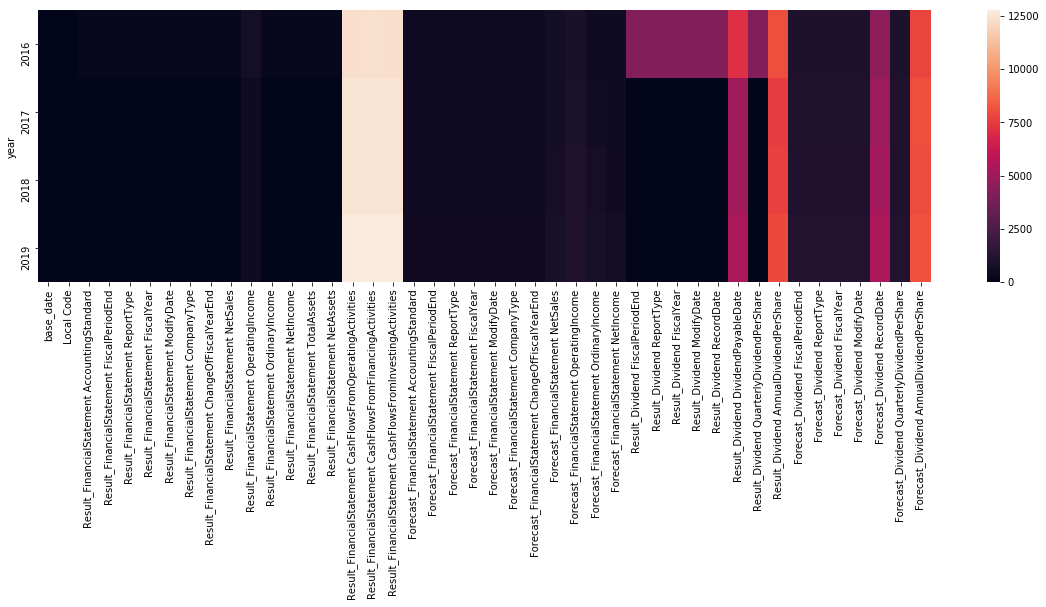

In [7]:
# stock_finデータを読み込む
stock_fin = dfs["stock_fin"]

# 2019年までの値を表示
stock_fin = stock_fin[:"2019"]

# データ数の確認
print(stock_fin.shape)

# データの欠損値数を確認
print(stock_fin.isna().sum())

# 欠損値の数を年別に集計
stock_fin = stock_fin.isna()
stock_fin["year"] = stock_fin.index.year

# データの欠損値をプロット
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(stock_fin.groupby("year").agg("sum"), ax=ax)

In [8]:
# stock_finデータを読み込む
stock_fin = dfs["stock_fin"]

# 銘柄コード9984にデータを絞る
code = 9984
stock_fin = stock_fin[stock_fin["Local Code"] == code]

# float64型の列に絞り込み
fin_data = stock_fin.select_dtypes(include=["float64"])

# 欠損値を0でフィル
fin_data = fin_data.fillna(0)

In [9]:
# stock_priceデータを読み込む
price = dfs["stock_price"]

# 銘柄コード9984にデータを絞る
code = 9984
price_data = price[price["Local Code"] == code]

# 終値のみに絞る
feats = price_data[["EndOfDayQuote ExchangeOfficialClose"]].copy()
# 終値の20営業日リターン
feats["return_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(20)
# 終値の40営業日リターン
feats["return_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(40)
# 終値の60営業日リターン
feats["return_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(60)
# 終値の20営業日ボラティリティ
feats["volatility_1month"] = (
    np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(20).std()
)
# 終値の40営業日ボラティリティ
feats["volatility_2month"] = (
    np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(40).std()
)
# 終値の60営業日ボラティリティ
feats["volatility_3month"] = (
    np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(60).std()
)
# 終値と20営業日の単純移動平均線の乖離
feats["MA_gap_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
    feats["EndOfDayQuote ExchangeOfficialClose"].rolling(20).mean()
)
# 終値と40営業日の単純移動平均線の乖離
feats["MA_gap_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
    feats["EndOfDayQuote ExchangeOfficialClose"].rolling(40).mean()
)
# 終値と60営業日の単純移動平均線の乖離
feats["MA_gap_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
    feats["EndOfDayQuote ExchangeOfficialClose"].rolling(60).mean()
)
# 欠損値処理
feats = feats.fillna(0)
# 元データのカラムを削除
feats = feats.drop(["EndOfDayQuote ExchangeOfficialClose"], axis=1)

In [10]:
TRAIN_END = "2017-12-31"
VAL_START = "2018-02-01"
VAL_END = "2018-12-01"
TEST_START = "2019-01-01"

In [11]:
def get_features_for_predict(dfs, code, start_dt="2016-01-01"):
    """
    Args:
        dfs (dict)  : dict of pd.DataFrame include stock_fin, stock_price
        code (int)  : A local code for a listed company
        start_dt (str): specify date range
    Returns:
        feature DataFrame (pd.DataFrame)
    """
    # おおまかな手順の1つ目
    # stock_finデータを読み込み
    stock_fin = dfs["stock_fin"]

    # 特定の銘柄コードのデータに絞る
    fin_data = stock_fin[stock_fin["Local Code"] == code]
    # 特徴量の作成には過去60営業日のデータを使用しているため、
    # 予測対象日からバッファ含めて土日を除く過去90日遡った時点から特徴量を生成します
    n = 90
    # 特徴量の生成対象期間を指定
    fin_data = fin_data.loc[pd.Timestamp(start_dt) - pd.offsets.BDay(n) :]
    # fin_dataのnp.float64のデータのみを取得
    fin_data = fin_data.select_dtypes(include=["float64"])
    # 欠損値処理
    fin_feats = fin_data.fillna(0)

    # おおまかな手順の2つ目
    # stock_priceデータを読み込む
    price = dfs["stock_price"]
    # 特定の銘柄コードのデータに絞る
    price_data = price[price["Local Code"] == code]
    # 終値のみに絞る
    feats = price_data[["EndOfDayQuote ExchangeOfficialClose"]]
    # 特徴量の生成対象期間を指定
    feats = feats.loc[pd.Timestamp(start_dt) - pd.offsets.BDay(n) :].copy()

    # 終値の20営業日リターン
    feats["return_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(20)
    # 終値の40営業日リターン
    feats["return_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(40)
    # 終値の60営業日リターン
    feats["return_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(60)
    # 終値の20営業日ボラティリティ
    feats["volatility_1month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(20).std()
    )
    # 終値の40営業日ボラティリティ
    feats["volatility_2month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(40).std()
    )
    # 終値の60営業日ボラティリティ
    feats["volatility_3month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(60).std()
    )
    # 終値と20営業日の単純移動平均線の乖離
    feats["MA_gap_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(20).mean()
    )
    # 終値と40営業日の単純移動平均線の乖離
    feats["MA_gap_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(40).mean()
    )
    # 終値と60営業日の単純移動平均線の乖離
    feats["MA_gap_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(60).mean()
    )

    # おおまかな手順の3つ目
    # 欠損値処理
    feats = feats.fillna(0)
    # 元データのカラムを削除
    feats = feats.drop(["EndOfDayQuote ExchangeOfficialClose"], axis=1)

    # 財務データの特徴量とマーケットデータの特徴量のインデックスを合わせる
    feats = feats.loc[feats.index.isin(fin_feats.index)]
    fin_feats = fin_feats.loc[fin_feats.index.isin(feats.index)]

    # データを結合
    feats = pd.concat([feats, fin_feats], axis=1).dropna()

    # 欠損値処理を行います。
    feats = feats.replace([np.inf, -np.inf], 0)

    # 銘柄コードを設定
    feats["code"] = code

    # 生成対象日以降の特徴量に絞る
    feats = feats.loc[pd.Timestamp(start_dt) :]

    return feats

In [12]:
df = get_features_for_predict(dfs, 9984)
df.T

datetime,2016-02-10 00:00:00,2016-04-21 00:00:00,2016-05-10 00:00:00,2016-07-28 00:00:00,2016-11-07 00:00:00,2017-02-08 00:00:00,2017-05-10 00:00:00,2017-08-07 00:00:00,2017-11-06 00:00:00,2018-02-07 00:00:00,2018-05-09 00:00:00,2018-08-06 00:00:00,2018-11-05 00:00:00,2019-02-06 00:00:00,2019-05-09 00:00:00,2019-08-07 00:00:00,2019-11-06 00:00:00,2020-02-12 00:00:00,2020-04-13 00:00:00,2020-04-30 00:00:00,2020-05-18 00:00:00,2020-08-11 00:00:00,2020-10-23 00:00:00,2020-11-09 00:00:00
return_1month,-1.913212e-01,8.908766e-02,8.688554e-02,-7.610193e-02,-3.968613e-02,2.224838e-02,8.804402e-02,9.961943e-03,8.356941e-02,-5.596001e-02,1.203510e-01,1.374653e-01,-2.102032e-01,8.878024e-02,5.914718e-02,-4.413740e-03,4.902913e-02,1.390374e-01,1.158342e-01,2.606803e-01,4.547511e-02,1.112701e-02,1.489293e-01,1.229098e-02
return_2month,0.000000e+00,1.441458e-01,2.409844e-02,-1.417147e-01,-7.741374e-02,1.144764e-01,4.466859e-02,-4.780498e-02,1.592260e-01,-6.940874e-02,7.893497e-03,1.775059e-01,-1.119797e-01,-1.097317e-01,1.015737e-01,1.675649e-02,-8.101212e-02,3.389988e-01,-2.304874e-01,-8.942610e-02,2.591281e-01,2.268081e-01,6.656627e-02,2.476660e-01
return_3month,0.000000e+00,2.555166e-01,1.739812e-01,-1.038744e-01,6.066667e-02,4.418064e-01,-3.892833e-03,4.227793e-02,1.126650e-01,-1.333666e-01,-1.530847e-02,1.065103e-01,-1.693257e-01,-3.258260e-02,3.665405e-01,3.811906e-02,-1.688462e-01,3.455779e-01,-1.564571e-01,2.409372e-02,-1.624071e-01,4.041943e-01,6.576373e-02,1.438953e-01
volatility_1month,4.402584e-02,1.717726e-02,2.271106e-02,3.175834e-02,1.816612e-02,1.522609e-02,1.157811e-02,1.171816e-02,1.838358e-02,1.995841e-02,1.387375e-02,2.234456e-02,4.054193e-02,1.672133e-02,1.514235e-02,2.397602e-02,1.696050e-02,3.441563e-02,8.639982e-02,3.362599e-02,2.807880e-02,2.506267e-02,1.671309e-02,2.384297e-02
volatility_2month,0.000000e+00,1.705030e-02,1.818629e-02,3.062359e-02,1.717361e-02,1.409169e-02,1.290494e-02,1.194563e-02,1.601125e-02,1.687287e-02,1.634615e-02,2.083745e-02,3.290983e-02,2.824798e-02,1.593598e-02,2.228841e-02,1.804909e-02,2.717941e-02,6.703024e-02,6.833698e-02,6.368045e-02,2.546068e-02,2.740215e-02,2.594448e-02
volatility_3month,0.000000e+00,3.428422e-02,3.271347e-02,2.758085e-02,1.972693e-02,1.948615e-02,1.331634e-02,1.679778e-02,1.444113e-02,1.580369e-02,1.608024e-02,1.943844e-02,2.879765e-02,2.756937e-02,2.729567e-02,2.419688e-02,1.791320e-02,2.312453e-02,5.856385e-02,6.008750e-02,5.734101e-02,2.369026e-02,2.694665e-02,2.668409e-02
MA_gap_1month,9.107187e-01,1.071322e+00,1.008618e+00,9.588478e-01,9.694274e-01,1.012936e+00,1.066627e+00,9.912226e-01,9.996080e-01,9.540805e-01,1.044586e+00,1.007283e+00,9.445341e-01,1.052259e+00,1.014114e+00,9.641599e-01,1.033230e+00,1.196816e+00,1.109218e+00,1.066639e+00,1.010287e+00,9.711673e-01,1.026183e+00,1.015520e+00
MA_gap_2month,0.000000e+00,1.067462e+00,1.037082e+00,9.375874e-01,9.660428e-01,1.050702e+00,1.070177e+00,9.902299e-01,1.054210e+00,9.530104e-01,1.043655e+00,1.074974e+00,8.712824e-01,1.046151e+00,1.043537e+00,9.861688e-01,9.938260e-01,1.218323e+00,9.579964e-01,1.119096e+00,1.100513e+00,1.052475e+00,1.073177e+00,1.051756e+00
MA_gap_3month,0.000000e+00,1.110128e+00,1.066974e+00,9.219905e-01,9.633156e-01,1.115042e+00,1.051330e+00,1.002253e+00,1.079846e+00,9.376535e-01,1.019751e+00,1.101696e+00,8.690109e-01,1.006648e+00,1.073046e+00,9.971634e-01,9.581661e-01,1.260576e+00,9.266409e-01,1.031623e+00,1.043319e+00,1.123141e+00,1.079417e+00,1.073711e+00
Result_FinancialStatement FiscalYear,2.016000e+03,2.016000e+03,2.016000e+03,2.017000e+03,2.017000e+03,2.017000e+03,2.017000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.019000e+03,2.019000e+03,2.019000e+03,2.019000e+03,2.020000e+03,2.020000e+03,2.020000e+03,2.020000e+03,2.020000e+03,2.020000e+03,2.021000e+03,2.021000e+03,2.021000e+03


In [13]:
def get_features_and_label(dfs, codes, feature, label):
    """
    Args:
        dfs (dict[pd.DataFrame]): loaded data
        codes  (array) : target codes
        feature (pd.DataFrame): features
        label (str) : label column name
    Returns:
        train_X (pd.DataFrame): training data
        train_y (pd.DataFrame): label for train_X
        val_X (pd.DataFrame): validation data
        val_y (pd.DataFrame): label for val_X
        test_X (pd.DataFrame): test data
        test_y (pd.DataFrame): label for test_X
    """
    # 分割データ用の変数を定義
    trains_X, vals_X, tests_X = [], [], []
    trains_y, vals_y, tests_y = [], [], []

    # 銘柄コード毎に特徴量を作成
    for code in tqdm(codes):
        # 特徴量取得
        feats = feature[feature["code"] == code]

        # stock_labelデータを読み込み
        stock_labels = dfs["stock_labels"]
        # 特定の銘柄コードのデータに絞る
        stock_labels = stock_labels[stock_labels["Local Code"] == code]

        # 特定の目的変数に絞る
        labels = stock_labels[label]
        # nanを削除
        labels.dropna(inplace=True)

        if feats.shape[0] > 0 and labels.shape[0] > 0:
            # 特徴量と目的変数のインデックスを合わせる
            labels = labels.loc[labels.index.isin(feats.index)]
            feats = feats.loc[feats.index.isin(labels.index)]
            labels.index = feats.index

            # データを分割（ホールドアウト法）
            _train_X = feats[: TRAIN_END]
            _val_X = feats[VAL_START : VAL_END]
            _test_X = feats[TEST_START :]

            _train_y = labels[: TRAIN_END]
            _val_y = labels[VAL_START : VAL_END]
            _test_y = labels[TEST_START :]

            # データを配列に格納 (後ほど結合するため)
            trains_X.append(_train_X)
            vals_X.append(_val_X)
            tests_X.append(_test_X)

            trains_y.append(_train_y)
            vals_y.append(_val_y)
            tests_y.append(_test_y)

    # 銘柄毎に作成した説明変数データを結合します。
    train_X = pd.concat(trains_X)
    val_X = pd.concat(vals_X)
    test_X = pd.concat(tests_X)
    # 銘柄毎に作成した目的変数データを結合します。
    train_y = pd.concat(trains_y)
    val_y = pd.concat(vals_y)
    test_y = pd.concat(tests_y)

    return train_X, train_y, val_X, val_y, test_X, test_y

In [14]:
# 対象銘柄コードを定義
codes = [9984]
# 対象の目的変数を定義
label = "label_high_20"
# 特徴量を取得
feat = get_features_for_predict(dfs, codes[0])
# 特徴量と目的変数を入力し、分割データを取得
ret = get_features_and_label(dfs, codes, feat, label)
for v in ret:
    print(v.T)

00000e+01  4.100000e+01  0.000000e+00  0.000000e+00   
code                                                9.984000e+03  9.984000e+03  9.984000e+03  9.984000e+03   

datetime                                              2016-11-07    2017-02-08    2017-05-10    2017-08-07  \
return_1month                                      -3.968613e-02  2.224838e-02  8.804402e-02  9.961943e-03   
return_2month                                      -7.741374e-02  1.144764e-01  4.466859e-02 -4.780498e-02   
return_3month                                       6.066667e-02  4.418064e-01 -3.892833e-03  4.227793e-02   
volatility_1month                                   1.816612e-02  1.522609e-02  1.157811e-02  1.171816e-02   
volatility_2month                                   1.717361e-02  1.409169e-02  1.290494e-02  1.194563e-02   
volatility_3month                                   1.972693e-02  1.948615e-02  1.331634e-02  1.679778e-02   
MA_gap_1month                                       9.694274e-01

In [16]:
def get_codes(dfs):
    """
    Args:
        dfs (dict[pd.DataFrame]): loaded data
    Returns:
        array: list of stock codes
    """
    stock_list = dfs["stock_list"].copy()
    # 予測対象の銘柄コードを取得
    codes = stock_list[stock_list["prediction_target"] == True][
        "Local Code"
    ].values
    return codes

In [17]:
# 対象の目的変数を定義
labels = {
    "label_high_5",
    "label_high_10",
    "label_high_20",
    "label_low_5",
    "label_low_10",
    "label_low_20",
}
# 目的変数毎にデータを保存するための変数
train_X, val_X, test_X = {}, {}, {}
train_y, val_y, test_y = {}, {}, {}

# 予測対象銘柄を取得
codes = get_codes(dfs)

# 特徴量を作成
buff = []
for code in tqdm(codes):
    feat = get_features_for_predict(dfs, code)
    buff.append(feat)
feature = pd.concat(buff)

# 目的変数毎に処理
for label in tqdm(labels):
    # 特徴量と目的変数を取得
    _train_X, _train_y, _val_X, _val_y, _test_X, _test_y = get_features_and_label(dfs, codes, feature, label)
    # 目的変数をキーとして値を保存
    train_X[label] = _train_X
    val_X[label] = _val_X
    test_X[label] = _test_X
    train_y[label] = _train_y
    val_y[label] = _val_y
    test_y[label] = _test_y

In [18]:
# 目的変数を指定
label = "label_high_20"
# モデルの初期化
pred_model = RandomForestRegressor(random_state=0)
# モデルの学習
pred_model.fit(train_X[label], train_y[label])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [19]:
# モデルを定義
models = {
    "rf": RandomForestRegressor,
}

# モデルを選択
model = "rf"

# 目的変数を指定
label = "label_high_20"

# 学習用データセット定義
# ファンダメンタル情報
fundamental_cols = dfs["stock_fin"].select_dtypes("float64").columns
fundamental_cols = fundamental_cols[fundamental_cols != "Result_Dividend DividendPayableDate"]
fundamental_cols = fundamental_cols[fundamental_cols != "Local Code"]
# 価格変化率
returns_cols = [x for x in train_X[label].columns if "return" in x]
# テクニカル
technical_cols = [x for x in train_X[label].columns if (x not in fundamental_cols) and (x != "code")]

columns = {
    "fundamental_only": fundamental_cols,
    "return_only": returns_cols,
    "technical_only": technical_cols,
    "fundamental+technical": list(fundamental_cols) + list(technical_cols),
}
# 学習用データセットを指定
col = "fundamental_only"

# 学習
pred_model = models[model](random_state=0)
pred_model.fit(train_X[label][columns[col]].values, train_y[label])

# 予測
result = {}
result[label] = pd.DataFrame(
    pred_model.predict(val_X[label][columns[col]]), columns=["predict"]
)

# 予測結果に日付と銘柄コードを追加
result[label]["datetime"] = val_X[label][columns[col]].index
result[label]["code"] = val_X[label]["code"].values

# 予測の符号を取得
result[label]["predict_dir"] = np.sign(result[label]["predict"])

# 実際の値を追加
result[label]["actual"] = val_y[label].values

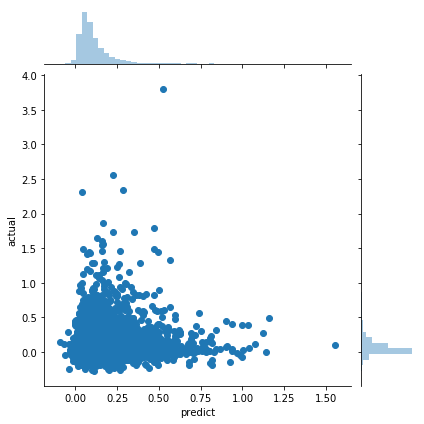

In [20]:
sns.jointplot(data=result[label], x="predict", y="actual")

Text(0.5, 0, 'Random Forest Feature Importance')

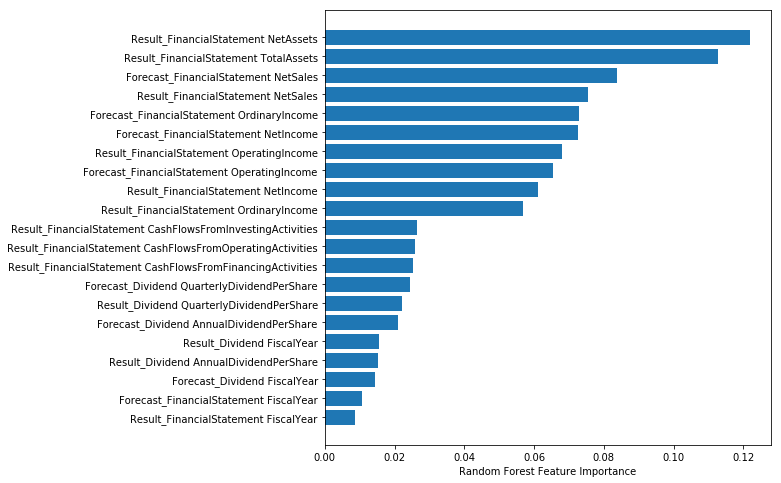

In [21]:
# 学習済みモデルを指定
rf = pred_model

# 重要度順を取得
sorted_idx = rf.feature_importances_.argsort()
# プロット
fig, ax = plt.subplots(figsize=(8, 8))
ax.barh(fundamental_cols[sorted_idx], rf.feature_importances_[sorted_idx])
ax.set_xlabel("Random Forest Feature Importance")